In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import ellipse
import sys; sys.path.append('../')
from processing import *
from utils import *
import subspaceMSI
import random
from tqdm import tqdm
from scipy.stats import pearsonr
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import pandas as pd
from signal_model import *

%matplotlib
import seaborn as sns

Using matplotlib backend: Qt5Agg


In [18]:
experiment = subspaceMSI.Subspace('../processed_data')
experiment.loadParams('../parameters/parameters_test.json')
T = 1/experiment.parameters['sw_h']
fid_length = 524288.0/2
calib = [107798997.08328888, 5.694034141537156, 0]
t = np.arange(0, fid_length)*T
f = experiment.parameters['sw_h']*np.arange(0, fid_length/2+1)/fid_length
m = fticr_mass_axis(f, calib)

loaded parameters for the experiment...
{'project_name': 'test', 'pixel_num_HR': 2000, 'fid_length_HR': 1048576, 'sw_h': 1428571.4285714286, 'n_basis': 150, 'fid_length_LR': 50000, 'CALIB': [107798997.08328888, 5.694034141537156, 0], 'T': 7e-07, 't_HR': array([0.000000e+00, 7.000000e-07, 1.400000e-06, ..., 7.340011e-01,
       7.340018e-01, 7.340025e-01]), 't_LR': array([0.00000e+00, 7.00000e-07, 1.40000e-06, ..., 3.49979e-02,
       3.49986e-02, 3.49993e-02]), 'f_HR': array([1.00000000e-01, 1.36239188e+00, 2.72478376e+00, ...,
       7.14282990e+05, 7.14284352e+05, 7.14285714e+05]), 'f_LR': array([1.00000000e-01, 2.85714286e+01, 5.71428571e+01, ...,
       7.14228571e+05, 7.14257143e+05, 7.14285714e+05]), 'm_HR': array([1.86051712e+07, 1.52767133e+07, 1.28045289e+07, ...,
       1.50917969e+02, 1.50917681e+02, 1.50917393e+02]), 'm_LR': array([1.86051712e+07, 3.14599566e+06, 1.71553676e+06, ...,
       1.50929467e+02, 1.50923430e+02, 1.50917393e+02])}


In [13]:
fid_length/4

65536.0

In [19]:
img = plt.imread('../100883804.png')
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray
grayscale = rgb2gray(img)
downsampled = downscale_local_mean(img,(50,50,1))

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9, random_state=0).fit(downsampled.reshape(downsampled.shape[0]*downsampled.shape[1],4))
labels = kmeans.labels_.copy()

for i in range(10):
    if np.sum(labels==i) <300:
        labels[labels==i] = 1
        
labels = labels.reshape(downsampled.shape[0],downsampled.shape[1])[:-2,:]

plt.imshow(labels,cmap='tab20b')
plt.figure(figsize=(10,5))
for i in range(1,9):
    labels_ = labels.copy()
    labels_[labels_!=i]=0
    labels_[labels_==i]=1
    plt.subplot(3,3,i)
    plt.title(i)
    plt.imshow(labels_)
plt.show()

c:\users\richard\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  after removing the cwd from sys.path.


In [9]:
import os
import glob

clean_data_folder = 'E:/simulated_data/clean_brain_new/'
noisy_data_folder = 'E:/simulated_data/noisy_brain_new/'

inds = np.where(labels.flatten() != 0)[0]
random.seed(19)
inds_sampled = random.sample(list(inds),1000)

In [16]:
clean_fid = []
noisy_fid = []
for i in tqdm(range(len(inds))):
    with open(noisy_data_folder+str(inds[i])+'.pkl', 'rb') as fp:
        fid = pickle.load(fp)
    with open('E:/simulated_data/noisy_brain_short_new/{}.pkl'.format(inds[i]), 'wb') as f:
        pickle.dump(fid[:int(fid_length/4)], f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(clean_data_folder+str(inds[i])+'.pkl', 'rb') as fp:
        fid_clean = pickle.load(fp)
    with open('E:/simulated_data/clean_brain_short_new/{}.pkl'.format(inds[i]), 'wb') as f:
        pickle.dump(fid_clean[:int(fid_length/4)], f, protocol=pickle.HIGHEST_PROTOCOL)

100%|████████████████████████████████████████████████████████████████████████████| 26497/26497 [46:41<00:00,  9.46it/s]


In [11]:
fid.shape

(262144,)

In [50]:
clean_peak_list = []
noisy_peak_list = []
for i in tqdm(range(len(inds))):
    with open(noisy_data_folder+str(inds[i])+'.pkl', 'rb') as fp:
        fid = pickle.load(fp)
    with open(clean_data_folder+str(inds[i])+'.pkl', 'rb') as fp:
        fid_clean = pickle.load(fp)
    mz,sp = fid2spec(fid, m, (150,1000))
    mz_clean,sp_clean = fid2spec(fid_clean, m, (150,1000))

    noisy_peak_list.append(sp[np.in1d(mz,mzs_use)])
    clean_peak_list.append(sp_clean[np.in1d(mz_clean,mzs_use)])

  0%|          | 38/26497 [00:05<1:00:49,  7.25it/s]


KeyboardInterrupt: 

In [29]:
noisy_data = np.stack(noisy_peak_list)
clean_data = np.stack(clean_peak_list)

with open('F:/simulated_data/peak_data_clean_2.pkl', 'wb') as f:
    pickle.dump(clean_data, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('F:/simulated_data/peak_data_noisy_2.pkl', 'wb') as f:
    pickle.dump(noisy_data, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('F:/simulated_data/peak_data_clean.pkl', 'rb') as fp:
#     clean_data = pickle.load(fp)
# with open('F:/simulated_data/peak_data_noisy.pkl', 'rb') as fp:
#     noisy_data = pickle.load(fp)

In [5]:
fid_length = t.size
latent_dims = [5]
signal_size = 10000

# for latent_dim in latent_dims:

#     model, encoder,decoder = ae_architecture(fid_length, latent_dim)
#     model.fit(noisy_data_sampled, noisy_data_sampled, epochs=10, batch_size=32)
#     encoded_HR = encoder(noisy_data_sampled)
#     model_lp = lp_architecture(signal_size, latent_dim)
#     model_lp.fit(noisy_data_sampled[:,:signal_size], encoded_HR, epochs=10, batch_size=32)

#     encoder.save('F:/simulated_data/saved_model/latent{}_encoder'.format(latent_dim))
#     decoder.save('F:/simulated_data/saved_model/latent{}_decoder'.format(latent_dim))
#     model_lp.save('F:/simulated_data/saved_model/latent{}_regressor'.format(latent_dim))

#     del encoder, decoder, model_lp

In [23]:
plt.scatter(decoded_)

(1, 111292)

In [23]:
with open('F:/simulated_data/peak_data_clean.pkl', 'rb') as fp:
    clean_data = pickle.load(fp)
with open('F:/simulated_data/peak_data_noisy.pkl', 'rb') as fp:
    noisy_data = pickle.load(fp)
with open('F:/simulated_data/data_recon_dict_noisy.pkl', 'rb') as fp:
    data_recon_dict_noisy = pickle.load(fp)

In [131]:
indices = np.arange(0,inds.size)
np.random.shuffle(indices)
inds[indices[1:1+128]]
inds

array([30707, 14875,  9718, ..., 25673, 31920,  8209], dtype=int64)

In [127]:
model, encoder,decoder = ae_architecture(fid_length, 10)

In [1]:
losses = trainDecoder(64,5,noisy_data_folder,inds,model)

In [104]:
data_folder = 'F:/simulated_data/noisy_brain/'
encoded = encodeSignal(128,data_folder,inds,encoder)

100%|██████████| 208/208 [16:00<00:00,  4.62s/it]


In [109]:
encoded.shape

(26497, 10)

In [114]:
np.in1d(inds,inds[:100]).shape

(26497,)

In [2]:
model_lp = lp_architecture(signal_size, 10)
inds = np.where(labels.flatten() != 0)[0]
losses_lp = trainRegressor(128, 10, encoded, signal_size, data_folder, inds, model_lp)

In [45]:
# with open('F:/simulated_data/noisy_brain_new_encoded.pkl', 'wb') as f:
#     pickle.dump(encoded, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('F:/simulated_data/noisy_brain_encoded.pkl', 'wb') as f:
#     pickle.dump(encoded, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('F:/simulated_data/noisy_brain_new_encoded_pred.pkl', 'wb') as f:
    pickle.dump(encoded_pred, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('F:/simulated_data/noisy_brain_new_encoded.pkl', 'rb') as fp:
    encoded = pickle.load(fp)

In [133]:
# encoder.save('F:/simulated_data/saved_model/latent10_encoder_alldata')
# decoder.save('F:/simulated_data/saved_model/latent10_decoder_alldata')
model_lp.save('F:/simulated_data/saved_model/latent10_regressor_alldata')

INFO:tensorflow:Assets written to: F:/simulated_data/saved_model/latent10_regressor_alldata\assets


In [7]:
model_lp = keras.models.load_model('F:/simulated_data/saved_model/latent10_regressor_alldata')
decoder = keras.models.load_model('F:/simulated_data/saved_model/latent10_decoder_alldata')
encoder = keras.models.load_model('F:/simulated_data/saved_model/latent10_encoder_alldata')

In [44]:
data_folder = 'F:/simulated_data/noisy_brain_new/'
inds = np.where(labels.flatten() != 0)[0]
encoded_pred = predictEncoded(128,data_folder,signal_size,inds,model_lp)

100%|██████████| 208/208 [14:09<00:00,  4.08s/it]


In [56]:
with open('F:/simulated_data/average_sp_clean.pkl', 'rb') as fp:
    average_sp_clean = pickle.load(fp)
mzs_use = peak_detection(mz,average_sp_clean,100,1000)['mz']

In [62]:
encoded_pred.shape

(26497, 10)

In [64]:
decoded_peak_list = []
for i in tqdm(range(len(inds))):
    decoded_HR = decoder(encoded_pred[i].reshape(1,-1))
    mz,sp = fid2spec(decoded_HR, m, (150,1000))
    decoded_peak_list.append(sp[:,np.in1d(mz,mzs_use)])

with open('F:/simulated_data/latent10_decoded_peak_data.pkl', 'wb') as f:
    pickle.dump(np.array(decoded_peak_list), f, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 26497/26497 [23:19<00:00, 18.93it/s]


In [202]:
clean_data_folder = 'F:/simulated_data/clean_brain_new/'
noisy_data_folder = 'F:/simulated_data/noisy_brain_new/'

inds = np.where(labels.flatten() != 0)[0]
random.seed(19)
inds_sampled = random.sample(list(inds),100)

noisy_data_sampled = np.zeros((len(inds_sampled), t.size))
clean_data_sampled = np.zeros((len(inds_sampled), t.size))

for i in range(len(inds_sampled)):
    print('reading spectra: {}...{}'.format(inds_sampled[i],i))
    with open(noisy_data_folder+ str(inds_sampled[i])+'.pkl', 'rb') as fp:
        noisy_data_sampled[i] = pickle.load(fp)

for i in range(len(inds_sampled)):
    print('reading spectra: {}...{}'.format(inds_sampled[i],i))
    with open(clean_data_folder+ str(inds_sampled[i])+'.pkl', 'rb') as fp:
        clean_data_sampled[i] = pickle.load(fp)

mz,sp_noisy = fid2spec(noisy_data_sampled[0], m, (150,1000))

reading spectra: 29332...0
reading spectra: 5210...1
reading spectra: 34100...2
reading spectra: 23848...3
reading spectra: 9108...4
reading spectra: 23545...5
reading spectra: 12499...6
reading spectra: 19582...7
reading spectra: 18006...8
reading spectra: 24144...9
reading spectra: 15952...10
reading spectra: 26047...11
reading spectra: 10306...12
reading spectra: 26398...13
reading spectra: 14944...14
reading spectra: 8524...15
reading spectra: 14923...16
reading spectra: 20199...17
reading spectra: 17307...18
reading spectra: 15196...19
reading spectra: 8523...20
reading spectra: 33378...21
reading spectra: 17245...22
reading spectra: 16733...23
reading spectra: 3504...24
reading spectra: 25513...25
reading spectra: 27186...26
reading spectra: 12569...27
reading spectra: 6685...28
reading spectra: 12599...29
reading spectra: 8807...30
reading spectra: 24602...31
reading spectra: 21671...32
reading spectra: 19419...33
reading spectra: 31449...34
reading spectra: 6879...35
reading sp

In [42]:
encoded = encoder(noisy_data_sampled)
decoded = np.array(decoder(encoded))

In [205]:
encoded_pred = predictEncoded(128,noisy_data_folder,signal_size,np.array(inds_sampled),model_lp)
decoded_pred = np.array(decoder(encoded_pred))

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


In [11]:
with open('F:/simulated_data/noisy_basis_100.pkl', 'rb') as fp:
    noisy_basis = pickle.load(fp)

In [206]:
projected = noisy_data_sampled @ noisy_basis[:10].T @ noisy_basis[:10]

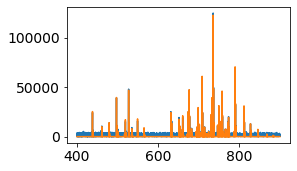

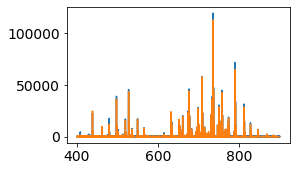

In [395]:
idx = 10
mz, sp = fid2spec(clean_data_sampled[idx], m, (150,1000))
mz, sp_noisy = fid2spec(noisy_data_sampled[idx], m, (150,1000))
mz, sp_projected = fid2spec(projected[idx], m, (150,1000))
mz, sp_decoded = fid2spec(decoded_pred[idx], m, (150,1000))
mz_mask = (mz>400)&(mz<900)

plt.figure(figsize=(4,2.5))
plt.plot(mz[mz_mask], sp_noisy[mz_mask], alpha=1)
plt.plot(mz[mz_mask], sp[mz_mask], alpha=1)
plt.figure(figsize=(4,2.5))
plt.plot(mz[mz_mask], sp_projected[mz_mask], alpha=1)
plt.plot(mz[mz_mask], sp_decoded[mz_mask], alpha=1)

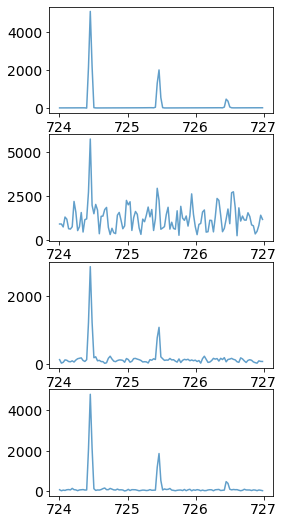

In [391]:
mz_mask = (mz>700)&(mz<730)
mz_mask = (mz>724)&(mz<727)

fig,axes = plt.subplots(4,1,figsize=(4,9))
ax = axes.ravel()
ax[0].plot(mz[mz_mask], sp[mz_mask], alpha=0.7)
ax[1].plot(mz[mz_mask], sp_noisy[mz_mask], alpha=0.7)
ax[2].plot(mz[mz_mask], sp_projected[mz_mask], alpha=0.7)
ax[3].plot(mz[mz_mask], sp_decoded[mz_mask], alpha=0.7)

In [110]:
l2_decoded = []
l2_projected = []
for i in tqdm(range(len(inds))):
    with open(clean_data_folder+ str(inds[i])+'.pkl', 'rb') as fp:
        fid_clean = pickle.load(fp)
    with open(noisy_data_folder+ str(inds[i])+'.pkl', 'rb') as fp:
        fid = pickle.load(fp)
        
    projected = fid @ noisy_basis[:10].T @ noisy_basis[:10]
    decoded = np.array(decoder(encoded_pred[i].reshape(1,-1)))

    mz, sp = fid2spec(fid_clean, m, (150,1000))
    mz, sp_projected = fid2spec(projected, m, (150,1000))
    mz, sp_decoded = fid2spec(decoded, m, (150,1000))
    mz_mask = (mz>150)&(mz<1000)
    
    l2_projected.append(np.linalg.norm(sp[mz_mask]-sp_projected[mz_mask])/np.linalg.norm(sp[mz_mask]))
    l2_decoded.append(np.linalg.norm(sp[mz_mask]-sp_decoded[0,mz_mask])/np.linalg.norm(sp[mz_mask]))

100%|██████████| 26497/26497 [1:09:12<00:00,  6.38it/s]


In [111]:
# with open('F:/simulated_data/l2error_spec_projected.pkl', 'wb') as f:
#     pickle.dump(l2_projected, f, protocol=pickle.HIGHEST_PROTOCOL)
# with open('F:/simulated_data/l2error_spec_decoded.pkl', 'wb') as f:
#     pickle.dump(l2_decoded, f, protocol=pickle.HIGHEST_PROTOCOL)

RanksumsResult(statistic=133.36042380305105, pvalue=0.0)

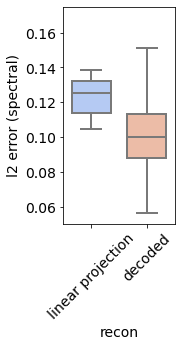

In [319]:
from scipy.stats import wilcoxon,ranksums
data = pd.DataFrame({'l2 error (spectral)':l2_projected+l2_decoded,'recon':['linear projection']*len(l2_projected)+['decoded']*len(l2_decoded)})
plt.figure(figsize=(2,4))
sns.boxplot(x='recon',y='l2 error (spectral)',data=data,showfliers=False,palette='coolwarm',linewidth=2,width=0.7)
plt.ylim([0.05,0.175])
plt.xticks(rotation=45)
ranksums(l2_projected,l2_decoded)

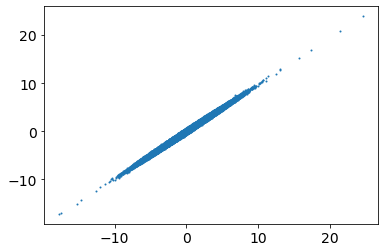

In [89]:
plt.scatter(clean_data_sampled[idx],decoded[idx],s=1)

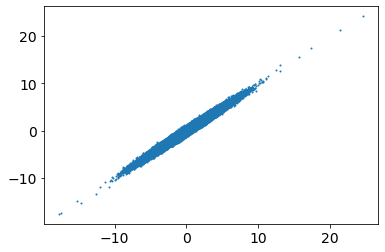

In [88]:
plt.scatter(clean_data_sampled[idx],projected[idx],s=1)

In [149]:
from sklearn.manifold import TSNE
embed_tsne = TSNE(random_state=19).fit_transform(encoded)
embed_tsne_pred = TSNE(random_state=19).fit_transform(encoded_pred)

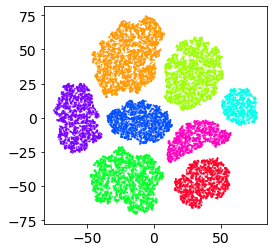

In [152]:
#test data encodings
plt.figure(figsize=(4,4))
plt.scatter(embed_tsne[:,0],embed_tsne[:,1],c=labels.flatten()[inds],s=0.5,alpha=0.5,cmap='gist_rainbow')

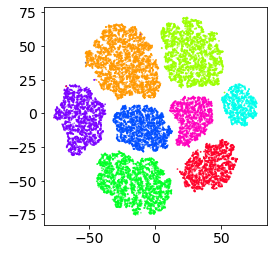

In [153]:
#predicted test data encodings
plt.figure(figsize=(4,4))
plt.scatter(embed_tsne_pred[:,0],embed_tsne_pred[:,1],c=labels.flatten()[inds],s=0.5,alpha=0.5,cmap='gist_rainbow')

In [65]:
with open('F:/simulated_data/peak_data_clean.pkl', 'rb') as fp:
    clean_data = pickle.load(fp)
with open('F:/simulated_data/peak_data_noisy.pkl', 'rb') as fp:
    noisy_data = pickle.load(fp)
with open('F:/simulated_data/latent10_decoded_peak_data.pkl', 'rb') as fp:
    decoded_data = pickle.load(fp)
with open('F:/simulated_data/peak_data_recon_new.pkl', 'rb') as fp:
    peak_data_recon = pickle.load(fp)

In [66]:
def ion_img(img_dim, inds, data):
    
    ion_img = np.zeros((img_dim[0]*img_dim[1]))
    ion_img[inds] = data
    ion_img = ion_img.reshape((img_dim[0],img_dim[1]))

    return ion_img

5 845.6741595994368


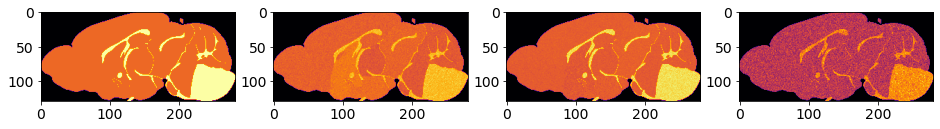

15 788.5655502919025


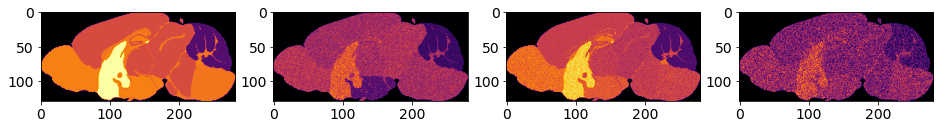

24 765.5843277345725


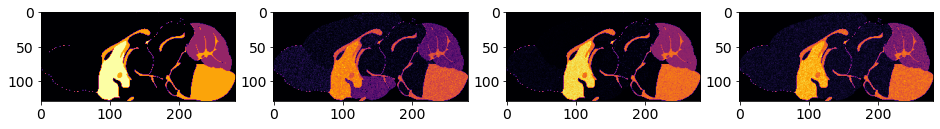

51 724.4522873166754


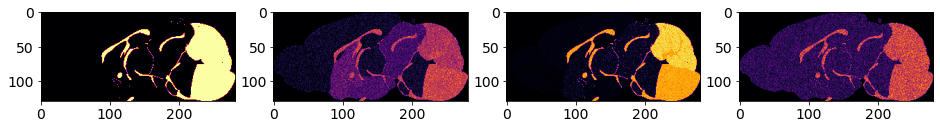

57 714.5860179098654


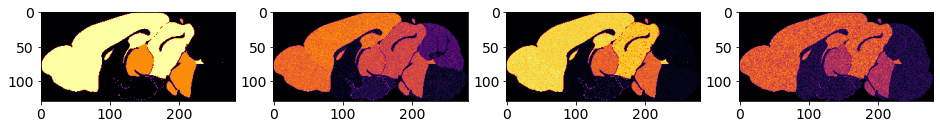

59 713.580685865586


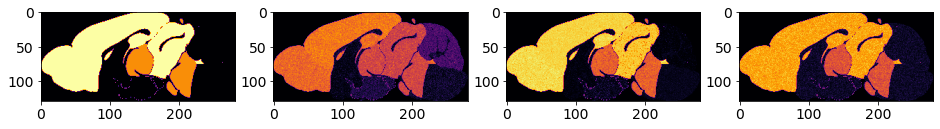

72 698.4876719615041


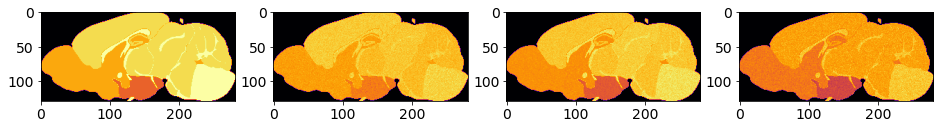

75 695.5160157258099


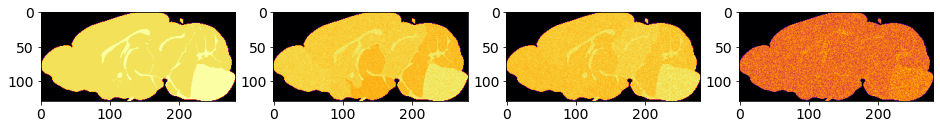

78 678.5062689960878


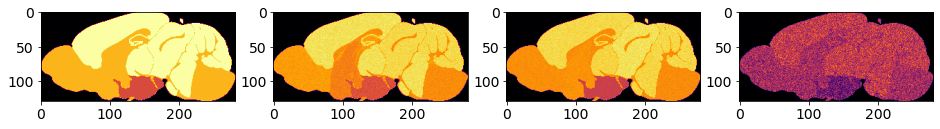

81 676.27938004136


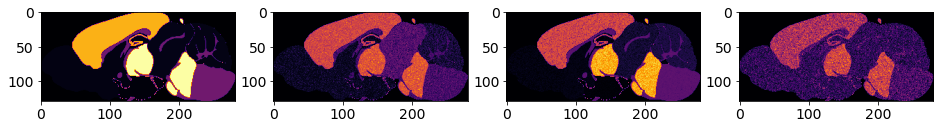

83 674.5497679045139


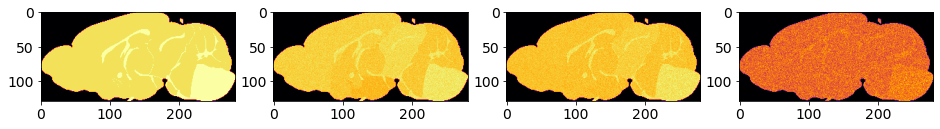

86 672.3258800748787


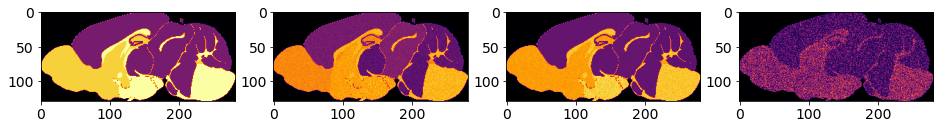

97 637.3211422729983


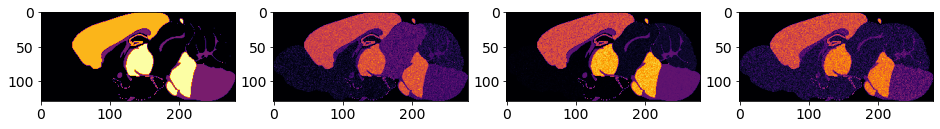

110 541.2679341870237


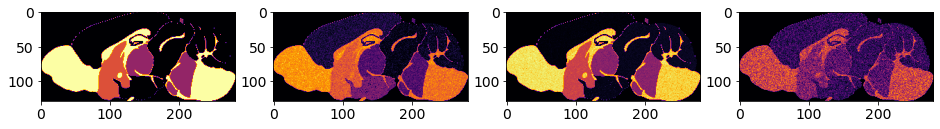

130 481.3407779618557


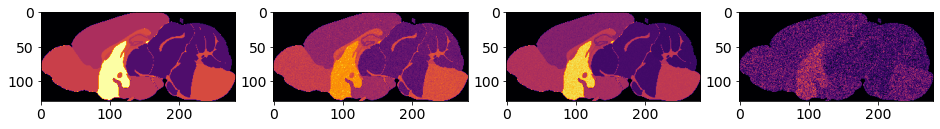

In [301]:
index = [5,15,24,51,57,59,72,75,78,81,83,86,97,110,130]
for idx in index:
    fig,axes = plt.subplots(1,4,figsize=(16,6))
    print(idx,mzs_use[idx])
    ax = axes.ravel()
    ax[0].imshow(ion_img(labels.shape,inds,clean_data[:,idx]),'inferno')
    ax[1].imshow(ion_img(labels.shape,inds,peak_data_recon[:,idx]),'inferno')
    ax[2].imshow(ion_img(labels.shape,inds,decoded_data[:,:,idx][:,0]),'inferno')
    ax[3].imshow(ion_img(labels.shape,inds,noisy_data[:,idx]),'inferno')
    plt.show()

In [312]:
areas = []
clean_intens = []
decoded_intens = []
recon_intens = []
decoded_intens_std = []
recon_intens_std = []
for i in range(1,9):
    area = labels.flatten()[inds]==i
    for j in range(clean_data.shape[1]):
        areas.append(i)
        clean_intens.append(np.mean(clean_data[:,j][area]))
        decoded_intens.append(np.mean(decoded_data[:,:,j].flatten()[area]))
        decoded_intens_std.append(np.std(decoded_data[:,:,j].flatten()[area]))
        recon_intens.append(np.mean(peak_data_recon[:,j][area]))
        recon_intens_std.append(np.std(peak_data_recon[:,j][area]))

(0.9995725717793494, 0.0)

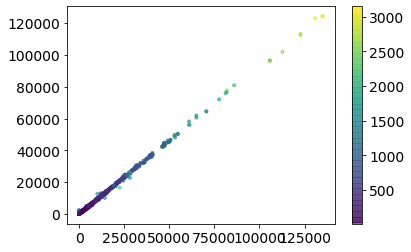

In [302]:
plt.scatter(clean_intens, decoded_intens,c=decoded_intens_std,alpha=0.6,s=9)
plt.colorbar()
pearsonr(clean_intens, decoded_intens)

(0.9964013607652098, 0.0)

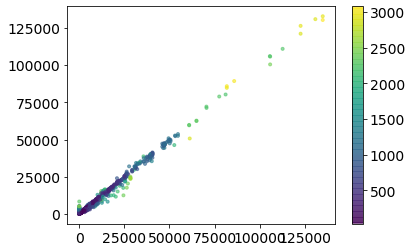

In [303]:
plt.scatter(clean_intens, recon_intens,c=recon_intens_std,alpha=0.6,s=9)
plt.colorbar()
pearsonr(clean_intens, recon_intens)

In [164]:
l2_decoded_spatial = []
l2_projected_spatial = []
for idx in range(clean_data.shape[1]):
    l2_decoded_spatial.append(np.linalg.norm(clean_data[:,idx]-decoded_data[:,0,idx])/np.linalg.norm(clean_data[:,idx]))
    l2_projected_spatial.append(np.linalg.norm(clean_data[:,idx]-peak_data_recon[:,idx])/np.linalg.norm(clean_data[:,idx]))

(array([0, 1]), [Text(0, 0, 'linear projection'), Text(1, 0, 'decoded')])

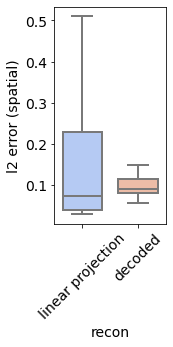

In [320]:
data = pd.DataFrame({'l2 error (spatial)':l2_projected_spatial+l2_decoded_spatial,'recon':['linear projection']*len(l2_projected_spatial)+['decoded']*len(l2_decoded_spatial)})
plt.figure(figsize=(2,4))
sns.boxplot(x='recon',y='l2 error (spatial)',data=data,showfliers=False,palette='coolwarm',linewidth=2,width=0.7)
plt.xticks(rotation=45)